In [25]:
from qiskit import QuantumCircuit, transpile
import numpy as np
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector
from scipy.linalg import expm

##### First we define some helping functions

In [105]:
# flattening functions to go from 2d lattice point to qubit number in the way i texted in the group about
def lattice_to_qubit(i, j, N):
    if i%2 == 0:
        return i*N + j
    else:
        return i*N + N -j -1

# inverse transformation
def qubit_to_lattice(q, N):
    # Calculate the row (i) and column (j) in the lattice
    i = q // N  # Integer division to get the row
    if i % 2 == 0:
        # For even rows, the qubit index increases left to right
        j = q % N
    else:
        # For odd rows, the qubit index increases right to left
        j = N - (q % N) - 1
    return i, j

# function to get neighbors of given point in qubit index
def get_neighbors(i, j, N):
    neighbors = []
    
    # Check top neighbor (i-1, j)
    if i - 1 >= 0:
        neighbors.append(lattice_to_qubit(i - 1, j, N))
    
    # Check bottom neighbor (i+1, j)
    if i + 1 < N:
        neighbors.append(lattice_to_qubit(i + 1, j, N))
    
    # Check left neighbor (i, j-1)
    if j - 1 >= 0:
        neighbors.append(lattice_to_qubit(i, j - 1, N))
    
    # Check right neighbor (i, j+1)
    if j + 1 < N:
        neighbors.append(lattice_to_qubit(i, j + 1, N))
    
    return neighbors

# implementing the W operator for XX and YY (for now)
# This does not work properly yet

def W(qc, N, t, M, g_matrix):
    for _ in range(M-1):
            for parity in [0, 1]:  # First even qubits, then odd qubits
                for i in range(1,N):
                    for j in range(1,N):
                        if (i + j) % 2 == parity:  # Checkerboard condition
                            neighbors = get_neighbors(i, j, N)
                            for neighbor in neighbors:
                                q1 = lattice_to_qubit(i, j, N)
                                q2 = neighbor
                                angle = g_matrix[q1, q2] * t / (2*M)
                                
                                qc.rxx(angle, q1, q2)
                                qc.ryy(angle, q1, q2)
    


In [136]:
# defining pauli matrices
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# function for pauli chain with I and X in indexed spots
def xixj(index1,index2,N):
    if index1 == 0 or index2 == 0:
        result = X
    else:
        result = I
    for i in range(1,N):
        if i == index1 or i == index2:
            result = np.kron(result,X)
        else:
            result = np.kron(result, I)
    return result

# function for pauli chain with I and Y in indexed spots
def yiyj(index1,index2,N):
    if index1 == 0 or index2 == 0:
        result = Y
    else:
        result = I
    for i in range(1,N):
        if i == index1 or i == index2:
            result = np.kron(result,Y)
        else:
            result = np.kron(result, I)
    return result

# function for pauli chain with I and Z in indexed spot
def zi(index,N):
    if index == 0:
        result = Z
    else:
        result = I
    for i in range(1,N):
        if i == index:
            result = np.kron(result,Z)
        else:
            result = np.kron(result, I)
    return result

# making a function for the XY model hamiltonian H
def Hamiltonian_unitary(J_matrix, g_matrix,N):
    H = np.zeros((2**(N**2), 2**(N**2)), dtype=np.complex128)
    interaction_count = [] # keeping track of pairs to only ocunt once
    for i in range(N):
        H += J_matrix[qubit_to_lattice(i,N)]*zi(i,N**2) # adding onsite potential
        for j in range(N):
            neighbors = get_neighbors(i,j, N) # getting nearest neighbors without periodic boundaries
            for neighbor in neighbors:
                q1 = lattice_to_qubit(i, j, N) # mapping to qubits with chessboard pattern
                q2 = neighbor
                if (q1,q2) not in interaction_count: # checking if the pair has already been counted
                    H += g_matrix[q1, q2]*xixj(q1,q2,N**2)/2 # applying the X term
                    H += g_matrix[q1, q2]*yiyj(q1,q2,N**2)/2 # applying the Y term
                    interaction_count.append((q2,q1))
    return H


def Ham_evo(H, t):
    if t%2 == 0: # to ensure alternatiion between W(1/2) and W(-1/2)
        op = Operator(expm(1j*H/2))
        op.label = "W(1/2)"
        return op
    else:
        op = Operator(expm(-1j*H/2))
        op.label = "W(-1/2)"
        return op
    


N = 2
J_test = np.random.rand(N,N)
G_test = np.random.rand(N**2,N**2)

J_test = np.ones((N,N))
G_test = np.ones((N**2,N**2))

H = Hamiltonian_unitary(J_test, G_test, N)
print(H.shape)

diag = np.linalg.eig(H)
print(np.round(diag[0],2))

# testing the operator functions
N = 3
qc = QuantumCircuit(N**2)
qc.unitary(xixj(1,6,N**2), range(N**2))
qc.unitary(zi(2,N**2), range(N**2))
state = Statevector(qc)
state.draw('latex')


(16, 16)
[-3.41+0.j -0.59+0.j -3.24+0.j  3.41+0.j  3.24+0.j -1.41+0.j -1.41+0.j
 -1.24+0.j  1.41+0.j  0.59+0.j  1.41+0.j  1.24+0.j  0.  +0.j -0.  +0.j
  2.  +0.j -2.  +0.j]


<IPython.core.display.Latex object>

#### Comments on this so far

We do a $N^2 +1$ qubit circuit, because we have the one control and a $N^2$ qubit hamiltonian, because each qubit models one spin site.
Then we apply the phases first in order.
There is a problem with the K-string: Since we have nearest neighbor terms and i flatten the NxN lattice to $N^2$ qubits with the formula i defined above. This only works for even values sidelength of the system we are trying to simulate though as there otherwise wont be a mapping to ensure all nearest neighbors are of different parity (i think).

Rn i am not sure if the order $K (W^{t/M})^M K$ is correct or if there are supposed to be some K's in between the trotter steps as well.

In [92]:



def XY_model_QETU(phi, N):
    # creating a quantum circuit with NxN qubits and one ancilla qubit
    qc = QuantumCircuit(N**2 + 1)
    
    for i in range(len(phi)-1):
        # applying the x rotation by the phase to the ancilla qubit
        qc.rx(phi[i], 0)

        # applying the controlled K string of pauli operators
        for i in range(int(N**2)): 
            if i%2 == 0:
                qc.cx(0, i+1)
            if i%2 == 1:
                qc.cy(0, i+1)
        
        # applying the hamiltonian evolution
        qc.append(Ham_evo(H, i), range(1,N**2+1))
        
        # applying the k-string again

        for i in range(int(N**2)):
            if i%2 == 0:
                qc.cx(0, i+1)
            if i%2 == 1:
                qc.cy(0, i+1)
        
    # applying the last x rotation
    qc.rx(phi[-1], 0)

    return qc


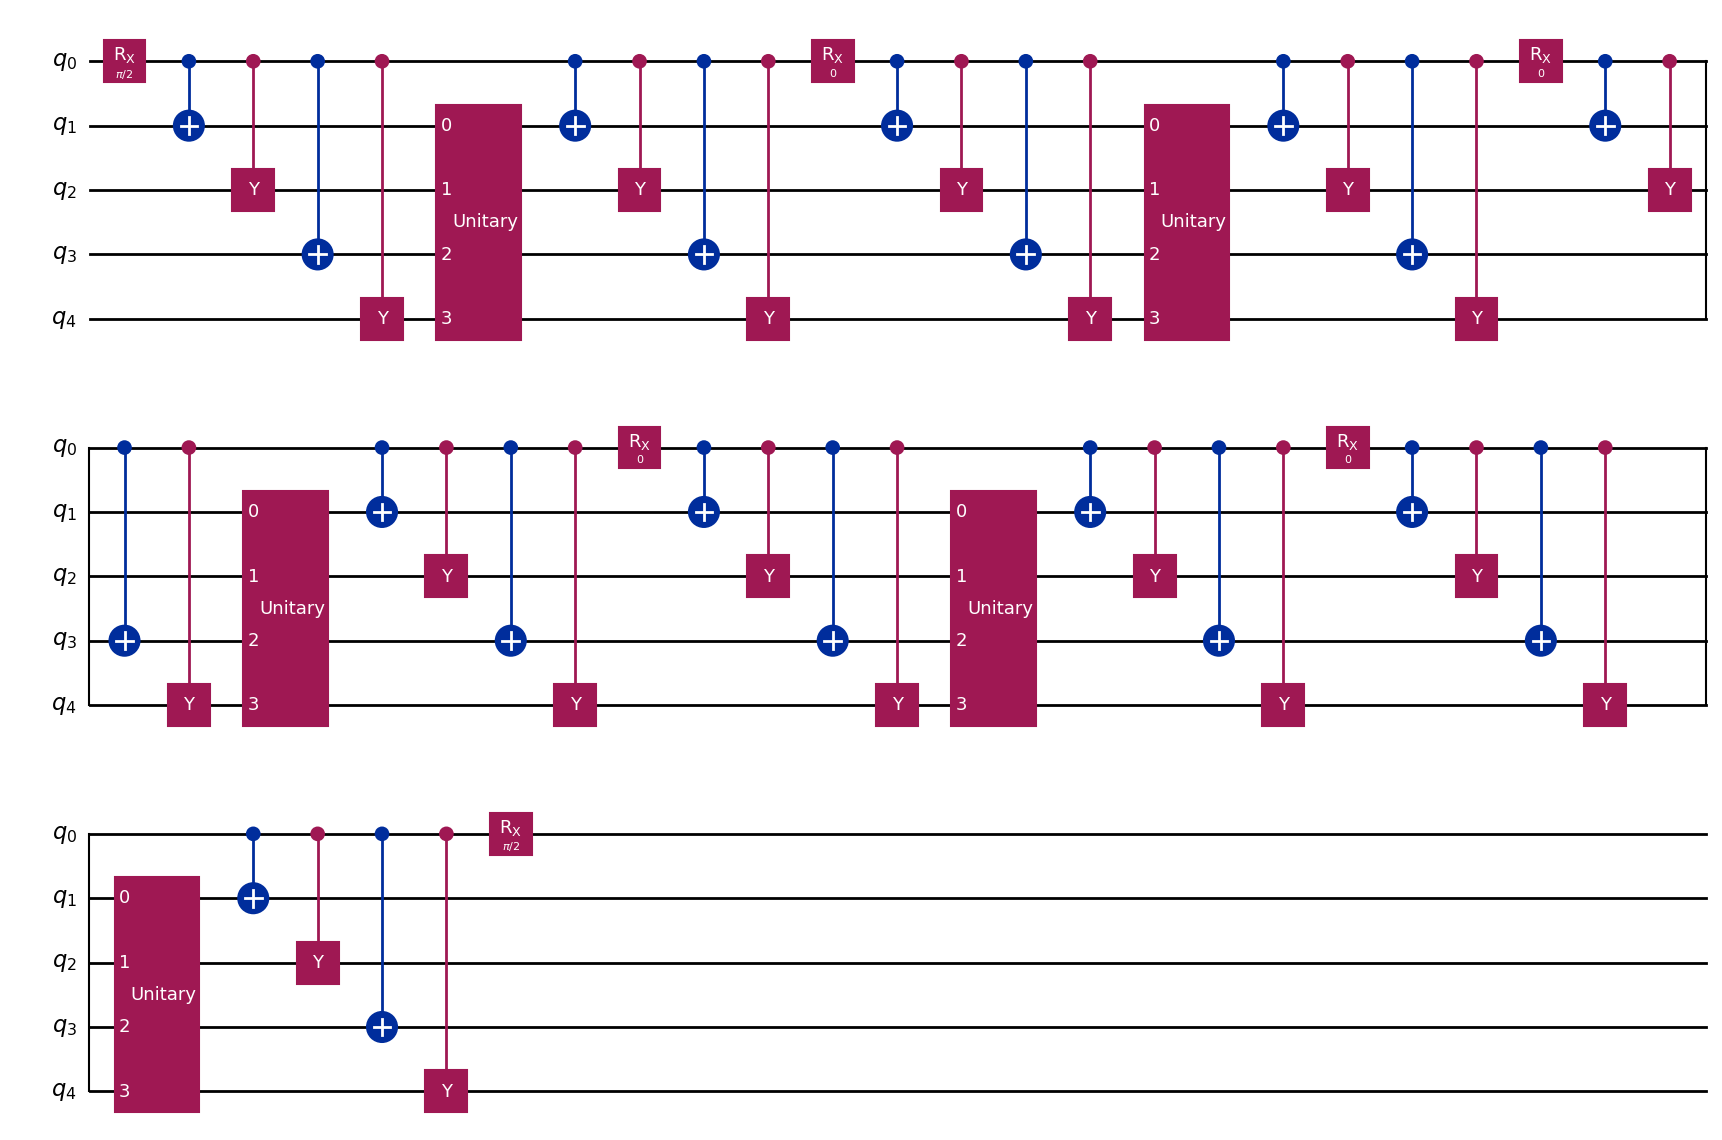

In [93]:
target_gates = ['cx', 'u3']
N = 2
t = 1
M = 3
phi = [np.pi/2,0,0,0,0, np.pi/2]
g_matrix = np.random.rand(N**2, N**2)
qc = XY_model_QETU(phi, N)
# qc = transpile(qc, basis_gates = target_gates)
qc.draw('mpl')